# This is the most up to date motor control example. Refer here to work with the FPGA through the network connection

In [599]:
import numpy as np
import matplotlib.pyplot as plt
import time

import sys
sys.path.append("..")
sys.path.append("../../")

from armControl import *
from forwardKinematics import robot_config
from utils.motor_setup import CableReduction
import signal

import matplotlib.pyplot as plt


In [601]:
socket_ip = '192.168.0.101'
socket_port = 1122

#trajPlanner = trajectoryGenerator()

motors = CableReduction()
motors.tcp_init(socket_ip, socket_port)

Opening socket at ip: 192.168.0.101 using port: 1122


In [602]:
print("Arming motors now...")
motors.arm_motors()


Arming motors now...
initializing motors to [0 0 0 0 0 0 0 0]
Arming motors


-0.0068329640215578635


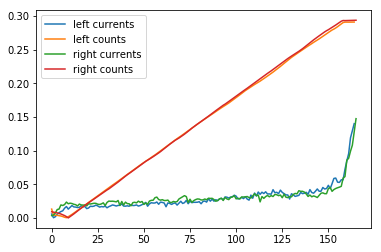

In [607]:
for i in range(1):
    setpoint = np.zeros(8)
    currents_left = []
    counts_left = []

    while motors.avg_current[0] < 0.15:
        setpoint = setpoint + 0.01
        currents_left.append(motors.avg_current[0])
        counts_left.append(motors.get_motors_position_radians())
        motors.command_motors_radians(setpoint)
        time.sleep(0.01)
    zero_left = motors.get_motors_position_radians()

    motors.run_trajectory(np.zeros(8), velocity)

    setpoint = np.zeros(8)    
    currents_right = []
    counts_right = []
    while motors.avg_current[0] < 0.15:
        setpoint = setpoint - 0.01
        currents_right.append(motors.avg_current[0])
        counts_right.append(motors.get_motors_position_radians())
        motors.command_motors_radians(setpoint)
        time.sleep(0.01)
    zero_right = motors.get_motors_position_radians()

    motor_zero_new = (zero_right[1] + zero_left[1])/2
    motors.zero_motors_radians(1, motor_zero_new)

    motors.run_trajectory(np.zeros(8), velocity)
    print(motor_zero_new)

currents_left = np.array(currents_left)
counts_left = np.array(counts_left)
currents_right = np.array(currents_right)
counts_right = np.array(counts_right)

plt.plot(currents_left)
plt.plot(np.abs(counts_left[:,1])/5)
plt.plot(currents_right)
plt.plot(np.abs(counts_right[:,1])/5)
plt.legend(['left currents', 'left counts', 'right currents', 'right counts'])

## Tuning gains based on oscillation

currents = []
positions = []

start = time.time()
while time.time() - start < 10:
    currents.append(motors.avg_current[0])
    positions.append(motors.get_motors_position_radians())
    time.sleep(0.01)

currents = np.array(currents)
positions = np.array(positions)

plt.plot(currents)
plt.plot(positions[:,1]/5)
plt.legend(['currents', 'position'])

Mean error: 11.677003236156613


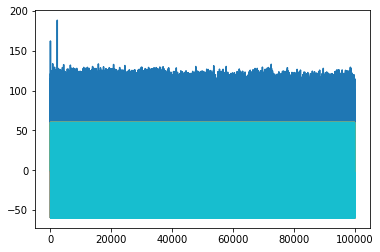

In [608]:
dt = 0.01
runtime = 1000
num_elements = int(runtime/dt)
setpoints = np.zeros((num_elements, 8))
frequency = 1
for i in range(num_elements):
    setpoints[i,:] = (np.ones(8) * np.sin(i*dt*2*pi*frequency)*3.14/3)


start_time = time.time()

currents_mA = []
counts = []
for i in range(num_elements):
    current_time = time.time()
    #print(enc_position)
    setpoint = setpoints[i]
    motors.command_motors_radians(setpoint)
    currents_mA.append(1000*motors.avg_current)
    counts.append(motors.get_motors_position_radians())
    time.sleep(dt)
    
motors.run_trajectory(np.zeros(8), velocity)

currents_mA = np.array(currents_mA)
counts = np.array(counts)
plt.plot(currents_mA[:,0])
plt.plot(counts[:,1]*180/np.pi)
plt.plot(setpoints*180/np.pi)

print('Mean error: {}'.format(np.mean(np.abs(counts[:,1]-setpoints[:,1]))*180/np.pi))

In [584]:
motors.tcp_close()